In [200]:
import matplotlib.pyplot as plt 
import os 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import numpy as np
from numpy import sum
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import  QuantileTransformer

# Load Dataset

In [79]:
data_path = "C:/Users/pudge/OneDrive/Desktop/skripsi/Dataset-Thesis/datasets" # Ganti berdasarkan path kalian simpen dimana

files = []
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))

print(files)

['C:/Users/pudge/OneDrive/Desktop/skripsi/Dataset-Thesis/datasets\\olist_customers_dataset.csv', 'C:/Users/pudge/OneDrive/Desktop/skripsi/Dataset-Thesis/datasets\\olist_geolocation_dataset.csv', 'C:/Users/pudge/OneDrive/Desktop/skripsi/Dataset-Thesis/datasets\\olist_orders_dataset.csv', 'C:/Users/pudge/OneDrive/Desktop/skripsi/Dataset-Thesis/datasets\\olist_order_items_dataset.csv', 'C:/Users/pudge/OneDrive/Desktop/skripsi/Dataset-Thesis/datasets\\olist_order_payments_dataset.csv', 'C:/Users/pudge/OneDrive/Desktop/skripsi/Dataset-Thesis/datasets\\olist_order_reviews_dataset.csv', 'C:/Users/pudge/OneDrive/Desktop/skripsi/Dataset-Thesis/datasets\\olist_products_dataset.csv', 'C:/Users/pudge/OneDrive/Desktop/skripsi/Dataset-Thesis/datasets\\olist_sellers_dataset.csv', 'C:/Users/pudge/OneDrive/Desktop/skripsi/Dataset-Thesis/datasets\\product_category_name_translation.csv']


# Ambil Dataset yang relevan dan di merge

In [80]:
# Read dataset
customers_dataset = pd.read_csv(f'{data_path}/olist_customers_dataset.csv')
geolocation_dataset = pd.read_csv(f'{data_path}/olist_geolocation_dataset.csv')
order_items_dataset = pd.read_csv(f'{data_path}/olist_order_items_dataset.csv')
order_payments_dataset = pd.read_csv(f'{data_path}/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv(f'{data_path}/olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv(f'{data_path}/olist_orders_dataset.csv')
products_dataset = pd.read_csv(f'{data_path}/olist_products_dataset.csv')
sellers_dataset = pd.read_csv(f'{data_path}/olist_sellers_dataset.csv')

In [81]:
# Sanity Data FORMAT (ENTRIES, COLUMN)
print("Customers Dataset: ", customers_dataset.shape)
print("Geolocation Dataset: ", geolocation_dataset.shape)
print("Order Items Dataset: ", order_items_dataset.shape)
print("Order Payments Dataset: ", order_payments_dataset.shape)
print("Order Reviews Dataset: ", order_reviews_dataset.shape)
print("Orders Dataset: ", orders_dataset.shape)
print("Products Dataset: ", products_dataset.shape)
print("Sellers Dataset: ", sellers_dataset.shape)

Customers Dataset:  (99441, 5)
Geolocation Dataset:  (1000163, 5)
Order Items Dataset:  (112650, 7)
Order Payments Dataset:  (103886, 5)
Order Reviews Dataset:  (99224, 7)
Orders Dataset:  (99441, 8)
Products Dataset:  (32951, 9)
Sellers Dataset:  (3095, 4)


# MERGE DATASET

In [82]:
#Merging all relevant datasets
merged_ds = pd.merge(customers_dataset, orders_dataset, on='customer_id', how='inner')
merged_ds = pd.merge(merged_ds, order_items_dataset, on='order_id', how='inner')
merged_ds = pd.merge(merged_ds, order_payments_dataset, on='order_id', how='inner')

In [83]:
# Sanity Data FORMAT (ENTRIES, COLUMN)
print("Merged Dataset: ", merged_ds.shape)

Merged Dataset:  (117601, 22)


In [84]:
# merged_ds snippet
merged_ds.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,credit_card,8,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,credit_card,7,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,credit_card,1,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,credit_card,8,252.25


In [85]:
# merged_ds info
merged_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    117601 non-null  object 
 1   customer_unique_id             117601 non-null  object 
 2   customer_zip_code_prefix       117601 non-null  int64  
 3   customer_city                  117601 non-null  object 
 4   customer_state                 117601 non-null  object 
 5   order_id                       117601 non-null  object 
 6   order_status                   117601 non-null  object 
 7   order_purchase_timestamp       117601 non-null  object 
 8   order_approved_at              117586 non-null  object 
 9   order_delivered_carrier_date   116356 non-null  object 
 10  order_delivered_customer_date  115034 non-null  object 
 11  order_estimated_delivery_date  117601 non-null  object 
 12  order_item_id                 

In [86]:
# drop columns that are not needed
rfm_col = [
    "customer_unique_id",
    "order_id",
    "order_purchase_timestamp",
    "payment_value"
]

# drop columns that are not needed
rfm_df = merged_ds[rfm_col].copy()

In [87]:
# convert order_purchase_timestamp to datetime
rfm_df['order_purchase_timestamp'] = pd.to_datetime(rfm_df['order_purchase_timestamp'])

In [88]:
# filter out rows that are not delivered (incomplete)
rfm_df = rfm_df[merged_ds['order_status'] == 'delivered'].copy()

In [89]:
# Sanity Data FORMAT (ENTRIES, COLUMN)
print("RFM Dataset: ", rfm_df.shape)

RFM Dataset:  (115035, 4)


In [90]:
# Count missing values
print("Count of missing values: ")
print(rfm_df.isnull().sum())

Count of missing values: 
customer_unique_id          0
order_id                    0
order_purchase_timestamp    0
payment_value               0
dtype: int64


In [91]:
# Print missing values
print("Missing values: ")
print(rfm_df[rfm_df.isnull().any(axis=1)])

Missing values: 
Empty DataFrame
Columns: [customer_unique_id, order_id, order_purchase_timestamp, payment_value]
Index: []


In [92]:
# Count duplicate values
print("Count of duplicate values: ")
print(rfm_df.duplicated().sum())

Count of duplicate values: 
14861


In [93]:
print(rfm_df[rfm_df.duplicated(keep=False)].shape)

(25132, 4)


In [94]:
# remove exact duplicates
rfm_df = rfm_df.drop_duplicates()

In [95]:
# Count duplicate values
print("Count of duplicate values: ")
print(rfm_df.duplicated().sum())

Count of duplicate values: 
0


In [96]:
# Sanity Data FORMAT (ENTRIES, COLUMN)
print("RFM Dataset: ", rfm_df.shape)

RFM Dataset:  (100174, 4)


In [97]:
# Finding Garbage
# Print unique values for each column
for i in rfm_df.select_dtypes(include="object").columns:
    print(f"Columns : {i}")
    print(rfm_df[i].value_counts())
    print("***"*10)

Columns : customer_unique_id
customer_unique_id
f9ae226291893fda10af7965268fb7f6    23
569aa12b73b5f7edeaa6f2a01603e381    22
2524dcec233c3766f2c2b22f69fd65f4    19
6fbc7cdadbb522125f4b27ae9dee4060    17
24f12460aad399ba18f4ed2c2fbab65d    17
                                    ..
8c19232ead49e981654300804a5eae9a     1
028f21bc914b92ebd3d90710df2363b0     1
8f40b2a65042866fae2f13df590824f6     1
bde87a8332a2a85c6fca9a60e47b1623     1
84732c5050c01db9b23e19ba39899398     1
Name: count, Length: 93357, dtype: int64
******************************
Columns : order_id
order_id
ccf804e764ed5650cd8759557269dc13    22
285c2e15bebd4ac83635ccc563dc71f4    19
fedcd9f7ccdc8cba3a18defedd1a5547    17
ee9ca989fc93ba09a6eddc250ce01742    17
465c2e1bee4561cb39e0db8c5993aafc    12
                                    ..
2cace2864447738573effeabd83eaa32     1
28785e42a86823ed810e8697382b4ceb     1
8435644661a27a84e873e6382328468f     1
6b0ac1bdea322c7060eea92feb9e9a6f     1
28db69209a75e59f20ccbb5c36a20b90 

# EDA

In [98]:
#DAMNNNN
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
rfm_df.describe(include='all')

,customer_unique_id,order_id,order_purchase_timestamp,payment_value
count,100174,100174,100174,100174.000000
unique,93357,96477,NaN,NaN
top,f9ae226291893fda10af7965268fb7f6,ccf804e764ed5650cd8759557269dc13,NaN,NaN
freq,23,22,NaN,NaN
mean,NaN,NaN,2017-12-31 18:01:23.108072192,153.784057
min,NaN,NaN,2016-10-03 09:44:50,0.000000
25%,NaN,NaN,2017-09-12 16:35:51.750000128,57.420000
50%,NaN,NaN,2018-01-19 10:19:27.500000,100.220000
75%,NaN,NaN,2018-05-04 18:44:51.750000128,171.790000
max,NaN,NaN,2018-08-29 15:00:37,13664.080000


In [99]:
# gimme some head
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100174 entries, 0 to 117600
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_unique_id        100174 non-null  object        
 1   order_id                  100174 non-null  object        
 2   order_purchase_timestamp  100174 non-null  datetime64[ns]
 3   payment_value             100174 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.8+ MB


In [100]:
# check duplicate order_id
rfm_df[rfm_df['order_id'].duplicated(keep=False)].sort_values(by=['order_id'])

,customer_unique_id,order_id,order_purchase_timestamp,payment_value
86121,33febb33a42a35f5826a22584b127f9d,0016dfedd97fc2950e388d2971d718c7,2017-04-28 19:54:40,52.63
86120,33febb33a42a35f5826a22584b127f9d,0016dfedd97fc2950e388d2971d718c7,2017-04-28 19:54:40,17.92
84780,d462d9e30ff3df8b64ade2aac3cafc7a,0071ee2429bc1efdc43aa3e073a5290e,2018-01-22 11:08:15,100.00
84781,d462d9e30ff3df8b64ade2aac3cafc7a,0071ee2429bc1efdc43aa3e073a5290e,2018-01-22 11:08:15,92.44
90693,1e5dec3847fa11b24069995161a7b95e,009ac365164f8e06f59d18a08045f6c4,2017-11-23 00:03:52,8.75
...,...,...,...,...
78391,26cbea974bc958bc0192ab80777f3a06,ffa1dd97810de91a03abd7bd76d2fed1,2017-05-22 22:35:09,418.73
108812,a86680d985911437a0c3f42c3f661b52,ffa39020fe7c8a3e907320e1bec4b985,2017-10-31 18:34:34,64.01
108813,a86680d985911437a0c3f42c3f661b52,ffa39020fe7c8a3e907320e1bec4b985,2017-10-31 18:34:34,7.13
67307,753891c0cbdd8778fb704e13fac815e8,ffc730a0615d28ec19f9cad02cb41442,2018-07-25 14:03:13,12.63


In [101]:
# gimme some head
rfm_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,payment_value
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,146.87
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,335.48
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,157.73
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,173.30
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,252.25


In [102]:
max_date = rfm_df['order_purchase_timestamp'].max()  # Store the latest date first

rfm_df = rfm_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,  # Use stored max_date
    'order_id': 'count',  # Frequency (Number of orders)
    'payment_value': 'sum'  # Monetary (Total spending)
}).reset_index()

rfm_df.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']

In [103]:
# Sanity Data FORMAT (ENTRIES, COLUMN)
print("RFM Dataset: ", rfm_df.shape)

RFM Dataset:  (93357, 4)


In [104]:
# gimme some head
rfm_df.describe()

,recency,frequency,monetary
count,93357.000000,93357.000000,93357.000000
mean,236.936673,1.073021,165.013487
std,152.584315,0.380994,226.210832
min,0.000000,1.000000,6.180000
25%,113.000000,1.000000,62.910000
50%,218.000000,1.000000,107.780000
75%,345.000000,1.000000,182.360000
max,694.000000,23.000000,13664.080000


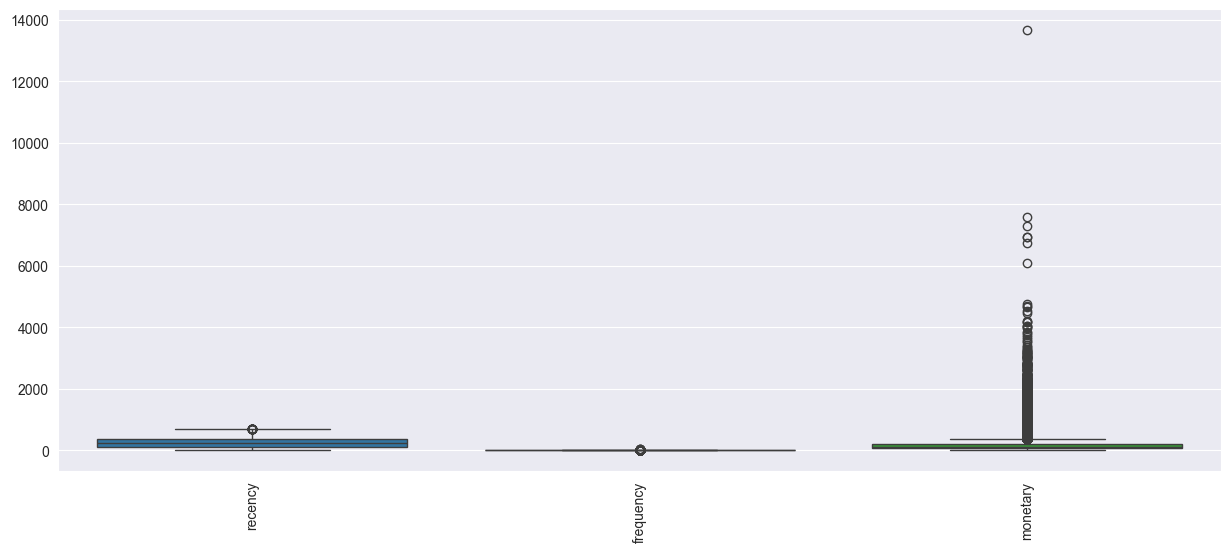

In [105]:
# Box plot to identify outliers 
plt.figure(figsize=(15, 6))
sns.boxplot(data=rfm_df.select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.show()

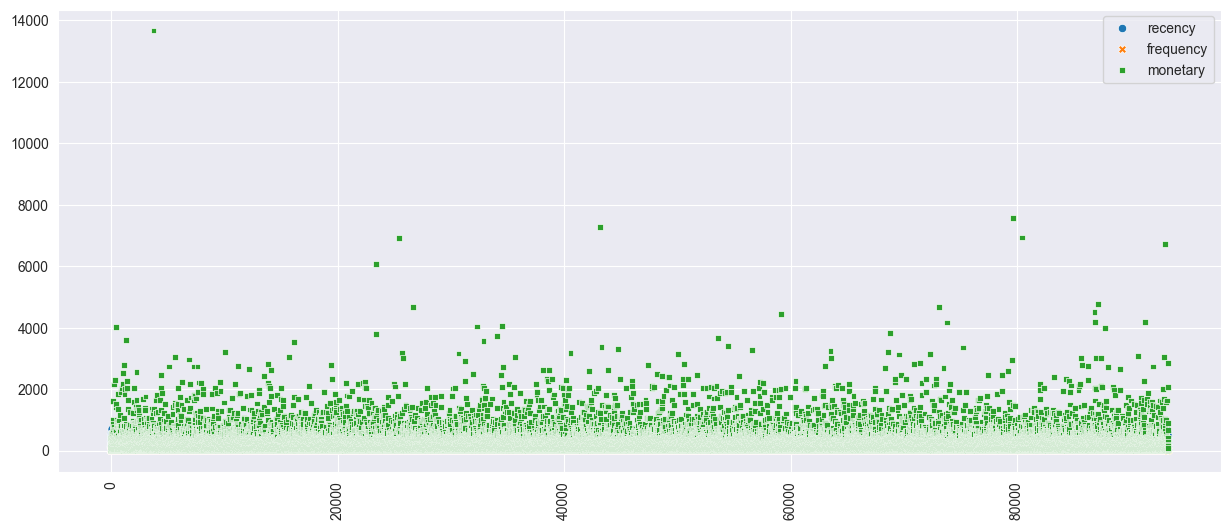

In [106]:
# Scatter Plot to identify outliers
plt.figure(figsize=(15, 6))
sns.scatterplot(data=rfm_df.select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.show()

In [201]:
# Duplicate data frame
removed_outlier_df = rfm_df.copy()

In [202]:
# remove outlier using z-score
z = np.abs(stats.zscore(rfm_df[['recency', 'monetary']]))
removed_outlier_df = rfm_df.loc[(z < 3).all(axis=1)]

# print how many outliers removed
print("Number of outliers removed:", rfm_df.shape[0] - removed_outlier_df.shape[0])

Number of outliers removed: 1612


In [203]:
# dislpay frewuency unique values and their count
print(removed_outlier_df['frequency'].value_counts())

frequency
1     86470
2      4578
3       482
4       119
5        30
6        21
7        13
11        7
8         6
10        5
9         4
12        3
17        2
14        2
19        1
22        1
23        1
Name: count, dtype: int64


In [162]:
# Because the frequency distribution is so skewed, we use log transformation to achieve a normal distribution
# yow johnson
removed_outlier_df['frequency'], _ = stats.yeojohnson(removed_outlier_df['frequency']) 

C:\Users\pudge\AppData\Local\Temp\ipykernel_12200\1012005692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_outlier_df['frequency'], _ = stats.yeojohnson(removed_outlier_df['frequency'])


In [169]:
# box cox transformation with +1 constant
removed_outlier_df['frequency'], _ = stats.boxcox(removed_outlier_df['frequency'] + 1)

C:\Users\pudge\AppData\Local\Temp\ipykernel_12200\3065737378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_outlier_df['frequency'], _ = stats.boxcox(removed_outlier_df['frequency'] + 1)


In [195]:
# quandandingle transformation
qt = QuantileTransformer(n_quantiles=5000, output_distribution='normal')
# removed_outlier_df['frequency'] = qt.fit_transform(removed_outlier_df['frequency'].values.reshape(-1, 1))
removed_outlier_df['frequency'] = qt.fit_transform(removed_outlier_df[['frequency']])

C:\Users\pudge\AppData\Local\Temp\ipykernel_12200\1887533654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_outlier_df['frequency'] = np.log1p(removed_outlier_df['frequency'])
C:\Users\pudge\AppData\Local\Temp\ipykernel_12200\1887533654.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_outlier_df['frequency'] = qt.fit_transform(removed_outlier_df[['frequency']])


In [204]:
# power transformation
pt = PowerTransformer(method='yeo-johnson')  # Handles non-positive values
removed_outlier_df['frequency'] = pt.fit_transform(removed_outlier_df[['frequency']])

C:\Users\pudge\AppData\Local\Temp\ipykernel_12200\252970177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_outlier_df['frequency'] = pt.fit_transform(removed_outlier_df[['frequency']])


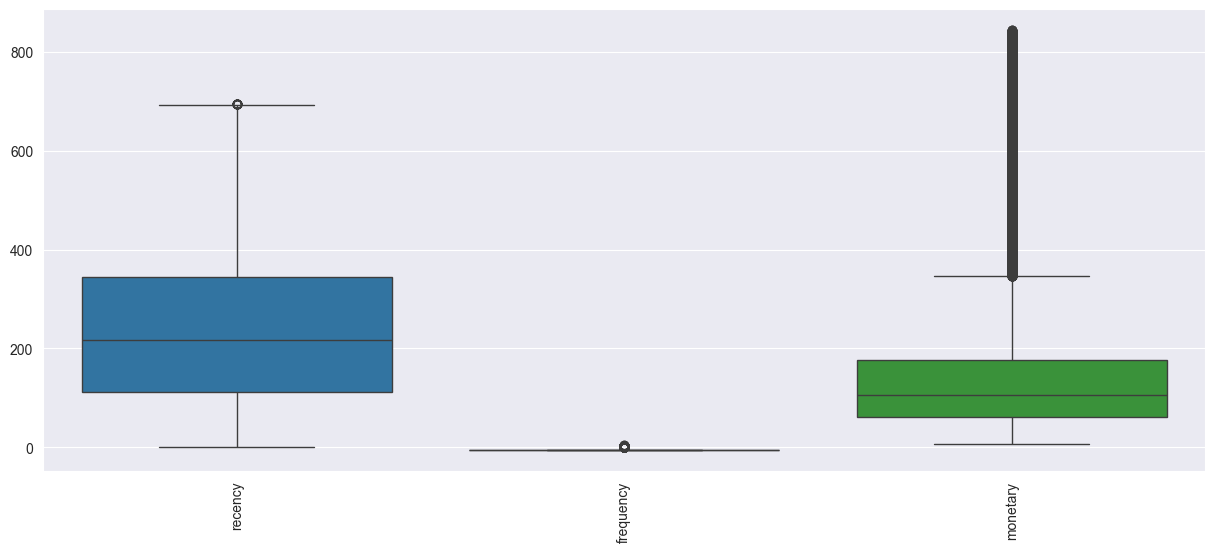

In [196]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=removed_outlier_df.select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.show()

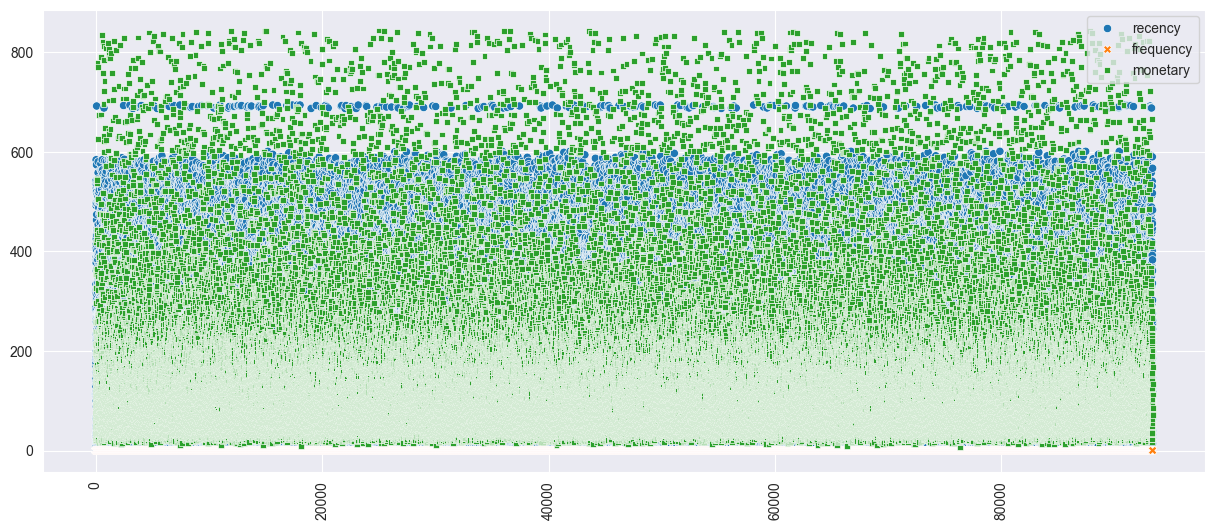

In [151]:
# Scatter Plot to identify outliers
plt.figure(figsize=(15, 6))
sns.scatterplot(data=removed_outlier_df.select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.show()

In [205]:
print(removed_outlier_df.describe())

            recency     frequency      monetary
count  91745.000000  9.174500e+04  91745.000000
mean     236.995727 -1.075663e-17    143.493323
std      152.539342  2.862641e-14    125.866673
min        0.000000 -7.081141e-15      6.180000
25%      113.000000 -7.081141e-15     62.310000
50%      218.000000 -7.081141e-15    106.070000
75%      345.000000 -7.081141e-15    176.200000
max      694.000000  1.158899e-13    843.620000


In [131]:
# BINNING CHILLLING if necessary
# sort
freq_counts = removed_outlier_df['frequency'].value_counts().sort_index()
print("Value distribution:", freq_counts)

def create_custom_bins(freq):
    if freq == 1:  
        return 0
    elif freq <= 3:  # occasional purchasers
        return 1
    elif freq <= 10:  # regular purchasers
        return 2
    else:  # loyal purchasers
        return 3
    
removed_outlier_df['frequency_binned'] = removed_outlier_df['frequency'].apply(create_custom_bins)
print(removed_outlier_df['frequency_binned'].value_counts())

Value distribution: frequency
0.00000    86470
0.04421     4578
0.04421      482
0.04421      119
0.04421       30
0.04421       66
Name: count, dtype: int64
frequency_binned
1    91745
Name: count, dtype: int64


C:\Users\pudge\AppData\Local\Temp\ipykernel_12200\3255062716.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_outlier_df['frequency_binned'] = removed_outlier_df['frequency'].apply(create_custom_bins)


In [206]:
# NORMALIZE DATA
scaler = MinMaxScaler()
normiez = scaler.fit_transform(removed_outlier_df.select_dtypes(include=['number']))

normalized_numeric_df = pd.DataFrame(normiez, columns=removed_outlier_df.select_dtypes(include=['number']).columns)

print("RAW DATA")
print(removed_outlier_df.select_dtypes(include=['number']).head())
print("NORMALIZED DATA")
print(normalized_numeric_df.head())

RAW DATA
   recency     frequency  monetary
0      111 -7.081141e-15    141.90
1      114 -7.081141e-15     27.19
2      536 -7.081141e-15     86.22
3      320 -7.081141e-15     43.62
4      287 -7.081141e-15    196.89
NORMALIZED DATA
    recency  frequency  monetary
0  0.159942        0.0  0.162065
1  0.164265        0.0  0.025088
2  0.772334        0.0  0.095577
3  0.461095        0.0  0.044708
4  0.413545        0.0  0.227730


In [207]:
print(normalized_numeric_df.describe())

            recency     frequency      monetary
count  91745.000000  91745.000000  91745.000000
mean       0.341492      0.057496      0.163968
std        0.219797      0.232790      0.150299
min        0.000000      0.000000      0.000000
25%        0.162824      0.000000      0.067026
50%        0.314121      0.000000      0.119280
75%        0.497118      0.000000      0.203024
max        1.000000      1.000000      1.000000


In [208]:
print(removed_outlier_df['frequency'].unique()) 

[-7.08114123e-15  1.15889937e-13]


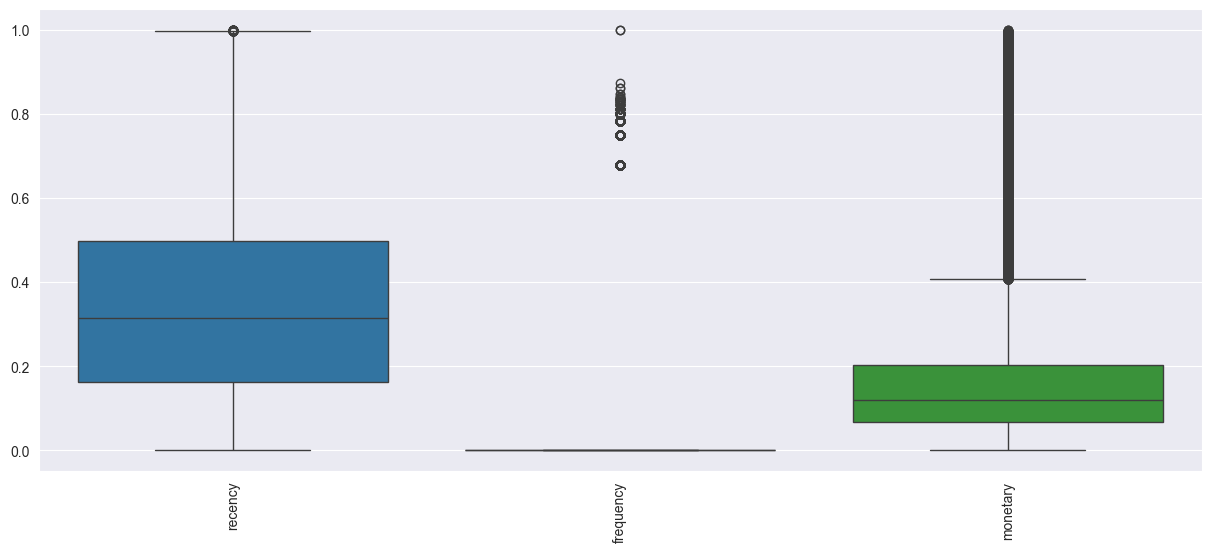

In [199]:
# BOX PLOT THAT THANG
plt.figure(figsize=(15, 6))
sns.boxplot(data=normalized_numeric_df)
plt.xticks(rotation=90)
plt.show()

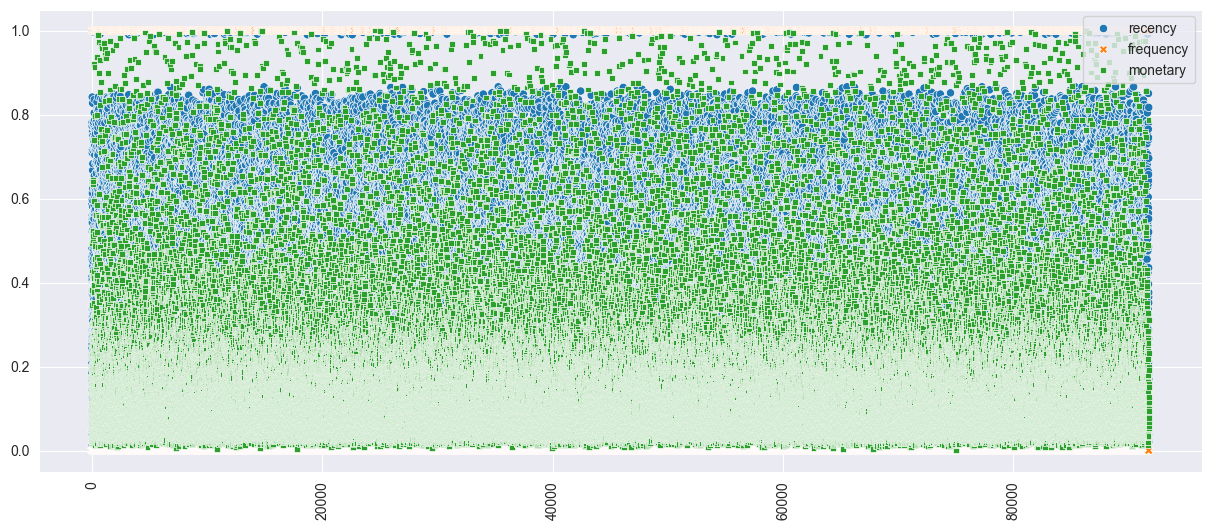

In [157]:
# Scatter Plot to identify outliers
plt.figure(figsize=(15, 6))
sns.scatterplot(data=normalized_numeric_df.select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.show()

In [190]:
# print unique frequency values and their count
print(removed_outlier_df['frequency'].value_counts())

frequency
-5.199338    86470
 1.883653     4578
 2.706417      482
 3.155848      119
 3.352739       30
 3.540042       21
 5.199338       17
 3.598505       13
 3.672660        6
 3.944362        5
 3.774972        4
Name: count, dtype: int64


#   Exploratory Data Analysis